In [1]:
#This program uses an artificial neural network called LSTM to predict the closing stock price.

In [7]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import yfinance as yf
plt.style.use('fivethirtyeight')

In [21]:
Apple = yf.download("AAPL",start = '2009-01-01', end='2023-05-07')

[*********************100%***********************]  1 of 1 completed


In [22]:
Apple

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-01-02,3.067143,3.251429,3.041429,3.241071,2.758536,746015200
2009-01-05,3.327500,3.435000,3.311071,3.377857,2.874956,1181608400
2009-01-06,3.426786,3.470357,3.299643,3.322143,2.827537,1289310400
2009-01-07,3.278929,3.303571,3.223571,3.250357,2.766438,753048800
2009-01-08,3.229643,3.326786,3.215714,3.310714,2.817809,673500800
...,...,...,...,...,...,...
2023-05-01,169.279999,170.449997,168.639999,169.589996,169.589996,52472900
2023-05-02,170.089996,170.350006,167.539993,168.539993,168.539993,48425700
2023-05-03,169.500000,170.919998,167.160004,167.449997,167.449997,65136000


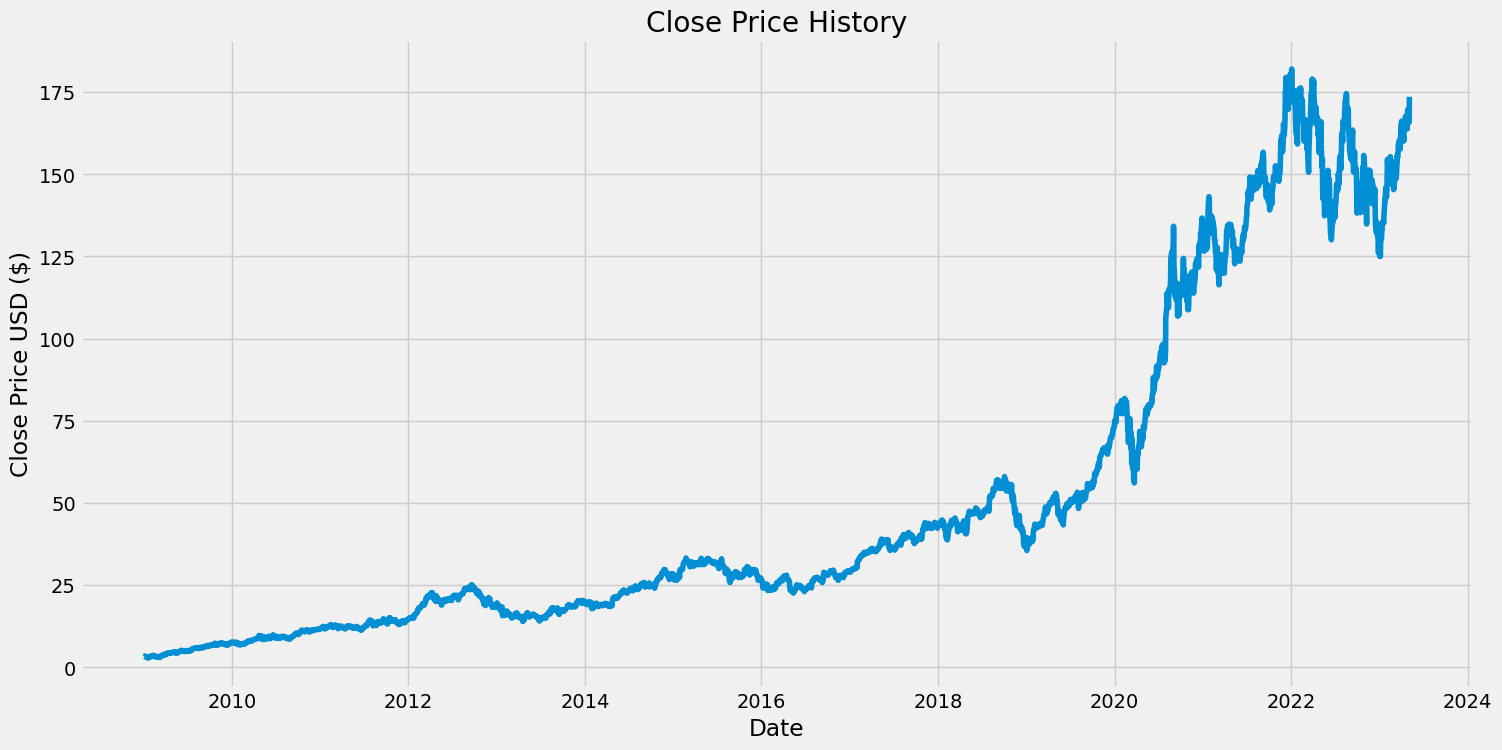

In [23]:
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(Apple['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.show()

In [24]:
#new data frame only wiuth the close column
data = Apple.filter(['Close'])
#covert the dataframe to a numpy array
dataset = data.values
#get the number of rows to train the model on 
training_data_len = math.ceil(len(dataset) * .8)

training_data_len


2888

In [25]:
#scale the data
#its always good practice to scale the data before presenting it to a neural network
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.00250096],
       [0.0032642 ],
       [0.00295332],
       ...,
       [0.91875778],
       [0.90949526],
       [0.95290636]])

In [91]:
#create the training dataset
#create the scaled training dataset
train_data = scaled_data[0:training_data_len,:]
#split the data into x_train and y_train datasets
x_train = []
y_train = []
for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])
    if i<= 60:
      print(x_train)
      print(y_train)
      print()

[array([0.00250096, 0.0032642 , 0.00295332, 0.00255277, 0.00288955,
       0.00246708, 0.00208447, 0.00189515, 0.00142086, 0.00103227,
       0.00082302, 0.        , 0.00092266, 0.00202468, 0.00202468,
       0.00227976, 0.00249697, 0.00318847, 0.00294934, 0.00237741,
       0.00265241, 0.00294535, 0.00305894, 0.00363884, 0.0042885 ,
       0.00484448, 0.00391186, 0.00371058, 0.00419882, 0.0041769 ,
       0.00325423, 0.00322235, 0.00247904, 0.00259063, 0.00174369,
       0.00240132, 0.00258266, 0.00219008, 0.002214  , 0.00194098,
       0.00202667, 0.00258465, 0.00212033, 0.00141489, 0.00097846,
       0.00207849, 0.00288557, 0.00361692, 0.00353322, 0.00343159,
       0.00427654, 0.0046472 , 0.00466713, 0.00466114, 0.00587077,
       0.00563961, 0.00563761, 0.00631118, 0.00570935, 0.00523906])]
[0.00536460481468721]



In [92]:
#convert the trains to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [93]:
#reshape the data because lstm expects input to be 3 dimensional and rn our x is 2 dimensional 
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_train.shape

(2828, 60, 1)

In [94]:
#build the LSTM model
model = Sequential()
model.add(LSTM(50,return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(50,return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [95]:
#compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [96]:
#train model
model.fit(x_train, y_train, batch_size=1, epochs = 1)

2828/2828 [==============================] - 91s 31ms/step - loss: 2.2264e-04


In [97]:
#create the testing da5ta set
#create a new array containing the scaled calues from indec 
test_data = scaled_data[training_data_len - 60: , :]
x_test = []
y_test = dataset[training_data_len:, :]
for i in range (60, len(test_data)):
  x_test.append(test_data[i-60:i,0])


In [98]:
#convert dat to a numpy array
x_test=np.array(x_test) 

In [99]:
#reshape
x_test = np.reshape(x_test,(x_test.shape[0], x_test.shape[1], 1))

In [100]:
#get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

23/23 [==============================] - 1s 16ms/step


In [101]:
#get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

3.1489161863881794

<ipython-input-102-219195cd86a1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


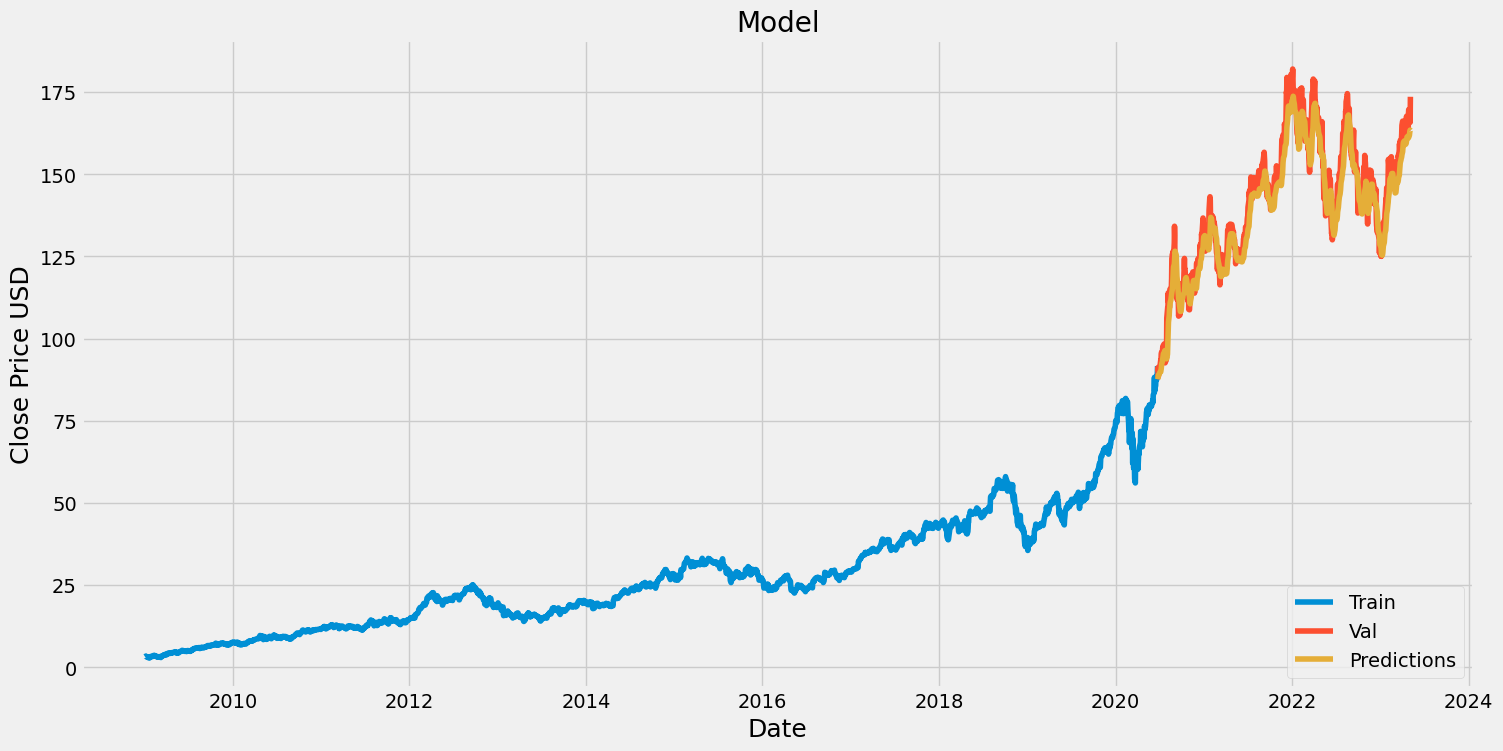

In [102]:
#plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date',fontsize = 18)
plt.ylabel('Close Price USD',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc = 'lower right')
plt.show()

In [103]:
#show valid and predicted prices
valid

,Close,Predictions
Date,,
2020-06-24,90.014999,87.657059
2020-06-25,91.209999,88.258301
2020-06-26,88.407501,88.849518
2020-06-29,90.445000,89.029198
2020-06-30,91.199997,89.217453
...,...,...
2023-05-01,169.589996,161.880432
2023-05-02,168.539993,162.596954
2023-05-03,167.449997,163.155182


In [104]:
#Get the quote
apple_quote = yf.download("AAPL",start = '2009-01-01', end='2023-05-15')

[*********************100%***********************]  1 of 1 completed


In [105]:
new_Apple = apple_quote.filter(['Close'])
last_60_days = new_Apple[-60:].values
last_60_days_scaled=scaler.transform(last_60_days)
X_test = []
X_test.append(last_60_days_scaled)
X_test=np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape [0], X_test.shape[1],1))
pred_price = model.predict(X_test)
pred_price=scaler.inverse_transform(pred_price)
print(pred_price)

1/1 [==============================] - 0s 42ms/step
[[164.00948]]
